##### **Importações**

In [207]:
#Importações necessárias para prosseguir com as implementações.
import re
import nltk 
import spacy
import csv
import numpy as np

import pandas as pd
from string import punctuation
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt

from unidecode import unidecode
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Qual é o melhor classificador?**

É importante ressaltar que o objetivo desta pesquisa é aprimorar um processo de extração de dados na web, conhecido como crawling, utilizando processamento de linguagem natural. A ideia principal é classificar imagens por meio do texto alternativo associado a elas, atribuindo-as a determinadas classes.

#### **1. Construção da base de dados.**

Como mencionado anteriormente, está sendo utilizado um script capaz de extrair informações de forma indiscriminada. Mas o que isso significa? A técnica conhecida como crawling tem como objetivo percorrer sites de forma automática e extrair dados deles. No contexto do projeto de pesquisa, foi estabelecido que o crawler deve seguir todos os links de uma página raiz específica e extrair todas as suas imagens juntamente com os respectivos textos alternativos. Dessa forma, é possível gerar uma base de dados que contenha imagens, texto e, consequentemente, o **rótulo** que será atribuído a eles de alguma maneira.

A fim de treinar o classificador, é necessário fornecer amostras positivas e negativas para que, em determinado momento, ele seja capaz de identificar por si só se uma determinada amostra é negativa ou positiva. Com isso, utilizamos um modelo de detecção chamado YOLO, mais especificamente o YOLOv7, para rotular as amostras de texto. Esse modelo recebe como entrada todas as imagens extraídas e retorna se uma imagem contém ou não a classe que desejamos rotular. Para o estudo de caso inicial, escolhemos a classe "cachorro", devido à existência de diversos trabalhos relacionados disponíveis na internet, assim como várias bases de dados que podem ser utilizadas para comparação. Através do retorno fornecido pela a YOLOv7, já era possível gerar uma base rotulada que poderia servir para treino e/ou teste futuramente.

##### **Pré processamento.**

Antes de iniciarmos efetivamente os processos de classificação, é essencial definir uma etapa importante na classificação de texto: o pré-processamento. Essa etapa desempenha um papel crucial quando estamos lidando com dados que podem apresentar uma grande variedade, como é o caso da extração de dados usando um crawler. Portanto, é necessário realizar uma análise prévia para identificar que tipos de informações devem ser removidas a fim de aprimorar a classificação. A seguir temos um método que será utiliza para pré-processar os textos utilizados durante todo o trabalho.

In [189]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def preprocess_text(text):

    text = str(text)
    
    #Deixando texto em caixa baixa.
    text = text.lower()

    #Removendo extensão
    text = re.sub('\.[^.\\/:*?"<>|\r\n]+$', '', text)

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # text = [word.lower() for word in text.split()]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

##### **Carregando base de dados de teste.**

Além de carregar a base dados, foi feito pré processamento no texto.

In [190]:
#Base de teste utilizado no momento:
test_dataset = pd.read_csv('./data/manual_labeled_test_dataset.csv')

test_dataset['is_not_dog'] = test_dataset['isdog']* -1 + 1
test_dataset.drop(columns=['isdog'], inplace=True)

#Cria uma nova coluna na tabela com os textos limpos.
test_dataset['text_clean'] = test_dataset['text'].apply(preprocess_text)

test_dataset

,text,is_not_dog,text_clean
0,Judy Ann Santos,1,judy ann santos
1,Sluishuis,1,sluishuis
2,King Charles III and Queen Camilla,1,king charles iii queen camilla
3,Frontispiece of the Diamond Sutra,1,frontispiece diamond sutra
4,Pinnularia,1,pinnularia
...,...,...,...
641,Brutus bullmastiff.jpg,0,brutus bullmastiff
642,PakistaniMastiffPunjab.jpg,0,pakistanimastiffpunjab
643,Burgos Pointer or Perdiguero de Burgos.JPG,0,burgos pointer perdiguero de burgos
644,Owczarek wschodnioeuropejski MB 01.jpg,0,owczarek wschodnioeuropejski mb


### **2. Processo de classificação.**

Para realizar um trabalho exploratório, iremos adotar três abordagens diferentes de classificação. Em seguida, faremos uma análise dos resultados, a fim de compreender as diferenças entre os classificadores, bem como suas vantagens e desvantagens em diferentes cenários.

#### **2.1 Gazetteer**

Primeiramente, é importante compreender a ideia de um gazetteer. Um gazetteer é uma técnica comum na área de Processamento de Linguagem Natural que consiste em criar uma lista de termos usados para verificar se determinado texto pertence a uma classe, com base na presença desses termos predefinidos. Inicialmente, o nosso gazetteer consistia em uma lista de raças de cachorros.

In [191]:
#Gazetteer inicial:
gazetteer = pd.read_csv('./data/gazetteer.csv')
gazetteer

,text
0,affenpinscher
1,afghan hound
2,africanis
3,aidi
4,airedale terrier
...,...
584,toy bulldog
585,toy trawler spaniel
586,turnspit dog
587,tweed water spaniel


#### **Método de verificação**

No primeiro modelo de gazetteer, o processo de verificação era realizado da seguinte maneira: inicialmente, tanto os termos do gazetteer quanto os textos a serem verificados eram divididos em n-gramas. Em seguida, percorríamos a lista de n-gramas dos termos, verificando se algum desses termos estava presente na lista de n-gramas do texto.

Após algumas análises, adotamos uma abordagem diferente que permitiu uma implementação mais simples. Realizamos uma reestruturação do gazetteer, subdividindo as raças em termos menores. Por exemplo, a raça "welsh hillman" foi subdividida em "welsh" e "hillman". Quanto à verificação, passamos a utilizar o operador "in" para verificar a ocorrência de substrings dentro de um texto, independentemente de estarem presentes dentro de uma palavra ou isoladamente. Essa mudança simplificou o processo de verificação.

Um ponto importante a ser mencionado é que, após a reformulação do gazetteer, algumas restrições foram aplicadas para evitar afirmações inapropriadas. Por meio de testes, chegamos ao resultado de definir um tamanho mínimo de 3 para os termos do gazetteer e evitar a inclusão de palavras de parada (stop words). A seguir, apresentaremos mais detalhes sobre a implementação dessas medidas.

In [192]:
#Definimos um conjunto (evita elemento iguais) para armazenar os subtermos do novo gazetteer.
new_gazetteer = set()

#Percorremos cada linha do arquivo para particionar os textos.
for linha in gazetteer['text']:
    for termo in linha.split():

        #Aqui estabelecemos o tamanho minimo da palavra que iremos aceitar do gzt.
        if len(termo) > 2:
            new_gazetteer.add(termo)

sw = stopwords.words('english')
new_gazetteer = list(new_gazetteer)
new_gazetteer = [word for word in new_gazetteer if word not in sw]
df = pd.DataFrame(new_gazetteer)
df.columns = ["text"]
df.to_csv("./data/new_gazetteer.csv", index=False)

#Gazetteer:
gazetteer = pd.read_csv('./data/new_gazetteer.csv')
gazetteer

,text
0,garafiano
1,bruxellois
2,agar
3,pachon
4,krysarik
...,...
635,serbian
636,king
637,fousek
638,xoloitzcuintle


##### **Classificando textos.**

Como dito anteriormente, a classificação se consiste em verficar se algum termo do gazetteer está contido no texto.

In [193]:
def verifica_texto(texto):
    for brd in new_gazetteer:
        if brd in texto:
            return 0
    return 1

#Gera uma coluna com os resultados.
test_dataset['gazetteer_result'] = test_dataset['text_clean'].apply(verifica_texto)
test_dataset.loc[(test_dataset['is_not_dog']==1)].count()
test_dataset

,text,is_not_dog,text_clean,gazetteer_result
0,Judy Ann Santos,1,judy ann santos,1
1,Sluishuis,1,sluishuis,1
2,King Charles III and Queen Camilla,1,king charles iii queen camilla,0
3,Frontispiece of the Diamond Sutra,1,frontispiece diamond sutra,1
4,Pinnularia,1,pinnularia,1
...,...,...,...,...
641,Brutus bullmastiff.jpg,0,brutus bullmastiff,0
642,PakistaniMastiffPunjab.jpg,0,pakistanimastiffpunjab,0
643,Burgos Pointer or Perdiguero de Burgos.JPG,0,burgos pointer perdiguero de burgos,0
644,Owczarek wschodnioeuropejski MB 01.jpg,0,owczarek wschodnioeuropejski mb,1


##### **Avaliação dos resultados.**
Como podemos ver adiante.

0.10884353741496598 0.4444444444444444 0.17486338797814205


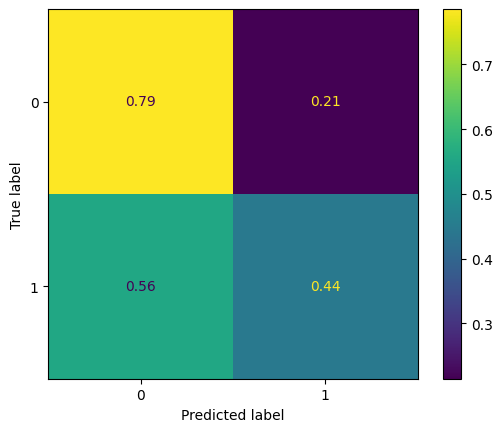

In [194]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

y_true = test_dataset['is_not_dog']
y_pred = test_dataset['gazetteer_result']

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true")
print(precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred))

### **2.2 Naive Bayes**

Agora que fizemos um "classificador" simples utilizando um conceito de PLN, iremos partir para uma abordagem mais elaborada e clássica. A ideia básica por trás do Naive Bayes é calcular a probabilidade de uma determinada classe (ou categoria) dado um conjunto de características. O algoritmo assume que cada característica contribui independentemente para a probabilidade final. Essa é uma suposição simplificadora, mas que permite um cálculo mais rápido e eficiente

##### **Base de dados de treinamento.**

O dataset de treinamento foi extraído do Wikipedia Dogs Breeds e de artigos aleatórios do Wikipedia. A escolha da base de dados está associado ao projeto de pesquisa.

In [195]:
#Bases de treino e teste.
train_csv = pd.read_csv('../naive-bayes/train_data.csv')
# test_csv = pd.read_csv('./data/manual_labeled_test_dataset.csv')
test_csv = pd.read_csv('../naive-bayes/test_data.csv')

##### Pré processando os textos de treino e teste.

In [196]:
#Cria uma nova coluna na tabela com os textos limpos.
train_csv['text_clean'] = train_csv['text'].apply(preprocess_text)
test_csv['text_clean'] = test_csv['text'].apply(preprocess_text)

#Definindo as colunas.
train_x = train_csv['text_clean'].values.astype('U')
train_y = train_csv['isdog']
test_x = test_csv['text_clean'].values.astype('U')
test_y = test_csv['isdog']

#### **Extração de características.**
Agora, podemos discutir uma etapa fundamental na classificação de texto, que é a extração de características. Essa etapa consiste em capturar informações relevantes dos dados textuais. Para o nosso estudo, utilizaremos uma técnica chamada TF-IDF (Term Frequency-Inverse Document Frequency), a qual classifica a relevância de um termo com base em sua frequência em um determinado documento, assim como em sua frequência em outros documentos. 

Para facilitar o entendimento, vamos utilizar um exemplo. Digamos que tenhamos três documentos: o primeiro fala sobre futebol, o segundo sobre vôlei e o terceiro sobre basquete. A técnica TF-IDF é capaz de identificar as palavras que são muito comuns em um documento específico, mas menos frequentes nos outros. Em outras palavras, se estivermos analisando o primeiro documento, é provável que palavras como "bola", "jogador", "gol" e "torcida" apareçam com frequência. Ao realizar a análise, podemos identificar facilmente qual dessas palavras (bola, jogador, gol e torcida) é mais relevante para classificar a classe de esportes, como o futebol, por exemplo. Nesse caso, a palavra "gol" seria destacada com um valor maior pelo vetorizador, enquanto as outras não teriam uma relevância tão grande, uma vez que também são frequentes nos outros textos que abordam diferentes esportes.

In [197]:
#Definios o vetorizador (Tfidf)
tfidf_vectorizer = TfidfVectorizer()

#A função a seguir tem como objetivo extrair as palavras únicas (fit) e gerar a matriz (transform) de frequências das palavras únicas extraídas.
x_train_tf = tfidf_vectorizer.fit_transform(train_x)

#Vocabulário e Features extraídas.
print(f'\nVocabulário: {len(tfidf_vectorizer.vocabulary_)} - {tfidf_vectorizer.vocabulary_}')
print("n_samples: %d, n_features: %d" % x_train_tf.shape)


Vocabulário: 10678 - {'affenpinscher': 174, 'also': 343, 'known': 5202, 'monkey': 6204, 'terrier': 9528, 'small': 8849, 'sized': 8793, 'like': 5536, 'toy': 9729, 'pinscher': 7214, 'breed': 1218, 'dog': 2798, 'originated': 6778, 'germany': 3904, 'distinctive': 2752, 'appearance': 490, 'charming': 1657, 'personality': 7107, 'gained': 3793, 'popularity': 7351, 'among': 381, 'lover': 5672, 'worldwide': 10508, 'afghan': 177, 'hound': 4462, 'distinguished': 2756, 'thick': 9577, 'fine': 3525, 'silky': 8742, 'coat': 1873, 'tail': 9401, 'ring': 8132, 'curl': 2354, 'end': 3095, 'selectively': 8508, 'bred': 1216, 'unique': 9993, 'feature': 3448, 'cold': 1890, 'mountain': 6255, 'afghanistan': 178, 'local': 5609, 'name': 6355, 'spay': 8962, 'pashto': 6973, 'sag': 8292, 'dari': 2429, 'balkh': 785, 'baluchi': 794, 'barakzai': 818, 'shalgar': 8617, 'kabul': 5013, 'galanday': 3798, 'sometimes': 8911, 'incorrectly': 4637, 'african': 180, 'sighthounds': 8723, 'ability': 17, 'run': 8258, 'fast': 3421, 't

In [198]:
#Agora, transformamos os textos de teste em uma matrix de features.
x_test_tf = tfidf_vectorizer.transform(test_x)
print("n_samples: %d, n_features: %d" % x_test_tf.shape)

n_samples: 552, n_features: 10678


#### **Treinando classificador**

In [199]:
from sklearn.naive_bayes import MultinomialNB

#Construindo o modelo de classificação.
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(x_train_tf, train_y)

#Realizando predição.
y_pred = naive_bayes_classifier.predict(x_test_tf)

#### **Análise de resultados.**

Accuracy:   0.996


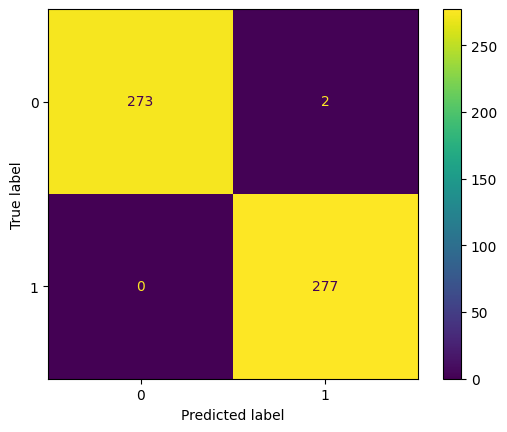

In [200]:
from sklearn import metrics

y_true = test_csv['isdog']

#Mostrando resultados.
ConfusionMatrixDisplay.from_predictions(test_y, y_pred)

score1 = metrics.accuracy_score(test_y, y_pred)
print("Accuracy:   %0.3f" % score1)

### **2.3 SVM**

Para essa abordagem será utilizada o Word2Vec para extração de características e o SVM como classificador.

In [201]:
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [202]:
# Carregar o modelo SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Codificar as sentenças de treinamento
train_sentences = train_csv['text_clean']  # Lista com as sentenças de treinamento
train_embeddings = model.encode(train_sentences)

# Codificar as sentenças de teste
test_sentences = test_csv['text_clean']  # Lista com as sentenças de teste
test_embeddings = model.encode(test_sentences)

In [203]:
train_labels = train_csv['isdog']  # Lista com os rótulos das sentenças de treinamento (0 ou 1)
test_labels = test_csv['isdog']  # Lista com os rótulos das sentenças de teste (0 ou 1)

In [204]:
# Criar uma instância do classificador SVM com kernel linear
svm = SVC(kernel='linear')

# Treinar o classificador SVM com validação cruzada
cross_val_scores = cross_val_score(svm, train_embeddings, train_labels, cv=5)

# Calcular a média das pontuações de validação cruzada
mean_cv_score = cross_val_scores.mean()

# Treinar o classificador SVM com todos os dados de treinamento
svm.fit(train_embeddings, train_labels)

SVC(kernel='linear')

In [205]:
# Fazer previsões nas sentenças de teste
predictions = svm.predict(test_embeddings)

# Calcular as métricas de avaliação
accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
confusion = confusion_matrix(test_labels, predictions)

# Imprimir as métricas de avaliação
print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.9963768115942029
F1-score: 0.9963898916967509
Recall: 0.9963898916967509
Confusion Matrix:
 [[274   1]
 [  1 276]]


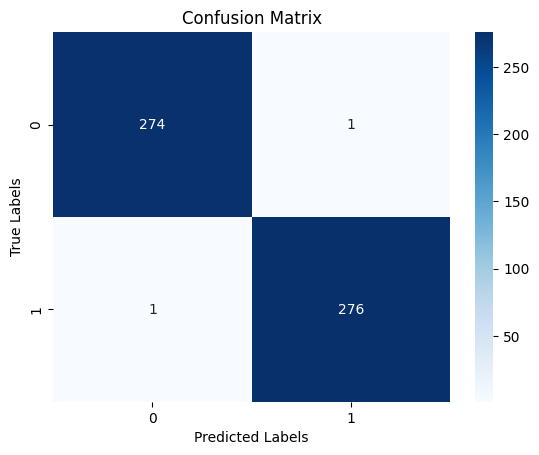

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar a matriz de confusão
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()